In [1]:
try:
    import warnings
    warnings.simplefilter(action='ignore', category=FutureWarning)
    import pandas as pd
    import numpy as np
    import os
    import statsmodels.api as sm
    import sklearn.linear_model as lm
    import sklearn.model_selection as skm
    import statsmodels.formula.api as smf
    import matplotlib.pyplot as plt
    from sklearn.preprocessing import StandardScaler
    from sklearn.pipeline import Pipeline
    from sklearn.model_selection import train_test_split
    from ISLP.models import ModelSpec as MS
    from stargazer.stargazer import Stargazer
    from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
    from sklearn.metrics import (accuracy_score,
                             log_loss,
                                mean_squared_error)
    from sklearn.ensemble import \
     (RandomForestRegressor as RF,
      GradientBoostingRegressor as GBR)
    from ISLP.bart import BART
    import xgboost as xgb
    from sklearn.model_selection import cross_val_predict
    from sklearn.neural_network import MLPRegressor
    #import doubleml as dml
    import graphviz
    import networkx as nx
    import dowhy
    from dowhy import CausalModel
    

except ModuleNotFoundError:
    !pip install ISLP -q
    !pip install stargazer -q
    !pip install xgboost -q
    !pip install doubleml -q
    !pip install dowhy -q
    import warnings
    warnings.simplefilter(action='ignore', category=FutureWarning)
    import pandas as pd
    import numpy as np
    import os
    import statsmodels.api as sm
    import sklearn.linear_model as lm
    import sklearn.model_selection as skm
    import statsmodels.formula.api as smf
    import matplotlib.pyplot as plt
    from stargazer.stargazer import Stargazer
    from sklearn.preprocessing import StandardScaler
    from sklearn.pipeline import Pipeline
    from sklearn.model_selection import train_test_split
    from ISLP.models import ModelSpec as MS
    from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
    from sklearn.metrics import (accuracy_score,
                             log_loss,
                                mean_squared_error)
    from sklearn.ensemble import \
     (RandomForestRegressor as RF,
      GradientBoostingRegressor as GBR)
    from ISLP.bart import BART
    import xgboost as xgb
    from sklearn.model_selection import cross_val_predict
    #import doubleml as dml
    import graphviz
    import networkx as nx
    import dowhy
    from dowhy import CausalModel

In [2]:
data_loc = "spillovers.dta"

data = pd.read_stata(data_loc, iterator=True)

In [3]:
data.variable_labels()

{'cusip': 'CUSIP',
 'year': 'year',
 'xrd': 'Expenditure on R&D',
 'ppent': 'Net book value of property, plant and equipment',
 'spillsic': 'SIC correlation weighted R&D of other firms, 1996 values',
 'spillcovsic': '',
 'spillmalsic': '',
 'spillmalcovsic': '',
 'spilltec': 'Patent NClass correlation weighted R&D of other firms, 1996 values',
 'spillcovtec': '',
 'spillmaltec': '',
 'spillmalcovtec': '',
 'spilltloc': '',
 'spillsloc': '',
 'spilltectloc': '',
 'spilltecsloc': '',
 'spillsicsloc': '',
 'spillsictloc': '',
 'lstate': '',
 'lfirm': '',
 'firm_dum': '',
 'hxrd': '',
 'spillsicIV': '',
 'spilltecIV': '',
 'spillsicIV_mal': '',
 'spilltecIV_mal': '',
 'p005': '',
 'sales_ind': 'Control variable - Total sales weighted by sic sales matrix',
 'sales_ind_ns': 'Control variable - Total Value Shipments in Manufacturing from National Statisti',
 'patents_ind': 'Control variable - Total number of patents weighted by tech matrix',
 'pat_count': 'Patents per firm applied for that ye

In [4]:
vars_of_int = ['i','year','rmkvaf','grd','grd_k1','rxrd','gspillsic','gspilltec','pat_count','pat_cite','rsales',
              'rppent','emp','gspilltecIV','gspillsicIV']

data = pd.read_stata(data_loc)
df = data[vars_of_int]
df.columns

Index(['i', 'year', 'rmkvaf', 'grd', 'grd_k1', 'rxrd', 'gspillsic',
       'gspilltec', 'pat_count', 'pat_cite', 'rsales', 'rppent', 'emp',
       'gspilltecIV', 'gspillsicIV'],
      dtype='object')

In [5]:
# convert categorical columns to strings
df['year'] = df['year'].astype(str)
df['i'] = df['i'].astype(str)

/tmp/ipykernel_417/3340598184.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = df['year'].astype(str)
/tmp/ipykernel_417/3340598184.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['i'] = df['i'].astype(str)


In [6]:
var_of_int_noindex = ['rmkvaf','gspilltecIV','gspillsicIV','pat_count','rsales','rppent','emp','rxrd']

# filter dataframe to variables of interest
df = df.drop(columns=['grd','grd_k1','pat_cite','gspilltec','gspillsic'])

# delete NaN values
df = df.dropna(axis=0)

#for i in range(0, len(var_of_int_noindex)):
#    df = df[df[var_of_int_noindex[i]].isna() == False]

#df = df.loc[df['rmkvaf'].isna() == False]

df_sum_stats = df[var_of_int_noindex].describe()
df_sum_stats = df_sum_stats.round(2)
df_sum_stats

,rmkvaf,gspilltecIV,gspillsicIV,pat_count,rsales,rppent,emp,rxrd
count,13385.00,13385.00,13385.00,13385.00,13385.00,13385.00,13385.00,13385.00
mean,3863.04,21341.64,6164.57,16.85,2852.77,1309.39,18.68,106.59
std,16402.81,16288.44,9019.92,75.96,8782.54,4070.72,53.65,473.90
min,0.43,230.28,4.31,0.00,1.08,0.91,0.10,0.00
25%,88.34,8991.68,607.00,0.00,117.32,27.22,1.09,0.00
50%,409.62,17508.95,2067.49,1.00,450.26,121.87,3.85,4.68
75%,1990.41,29810.46,7534.20,5.00,1950.00,731.75,14.00,30.19
max,485566.69,92324.67,55576.60,2405.00,140609.58,72825.98,876.80,8900.00


In [7]:
#df_sum_stats.T.to_excel("sum_stats.xlsx") # export summary statistics
print(df_sum_stats.T.to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
 & count & mean & std & min & 25% & 50% & 75% & max \\
\midrule
rmkvaf & 13385.000000 & 3863.040000 & 16402.810000 & 0.430000 & 88.340000 & 409.620000 & 1990.410000 & 485566.690000 \\
gspilltecIV & 13385.000000 & 21341.640000 & 16288.440000 & 230.280000 & 8991.680000 & 17508.950000 & 29810.460000 & 92324.670000 \\
gspillsicIV & 13385.000000 & 6164.570000 & 9019.920000 & 4.310000 & 607.000000 & 2067.490000 & 7534.200000 & 55576.600000 \\
pat_count & 13385.000000 & 16.850000 & 75.960000 & 0.000000 & 0.000000 & 1.000000 & 5.000000 & 2405.000000 \\
rsales & 13385.000000 & 2852.770000 & 8782.540000 & 1.080000 & 117.320000 & 450.260000 & 1950.000000 & 140609.580000 \\
rppent & 13385.000000 & 1309.390000 & 4070.720000 & 0.910000 & 27.220000 & 121.870000 & 731.750000 & 72825.980000 \\
emp & 13385.000000 & 18.680000 & 53.650000 & 0.100000 & 1.090000 & 3.850000 & 14.000000 & 876.800000 \\
rxrd & 13385.000000 & 106.590000 & 473.900000 & 0.000000 & 0.000000 & 4.

# OLS Regression

In [8]:
# Run linear model
# gen fixed effects
time_effects = pd.get_dummies(df['year'])
#time_effects.columns = time_effects.columns.astype(str)
firm_effects = pd.get_dummies(df['i'])
#time_effects.columns = time_effects.columns.astype(str)


df = pd.merge(df, time_effects, left_on=df.index, right_on=time_effects.index, how='left')

df = df.rename(columns={'key_0': 'old_key'})

df = pd.merge(df, firm_effects, left_on=df['old_key'], right_on=firm_effects.index, how='left')

fixed_effects = list(time_effects.columns.values)
for col in firm_effects.columns.values:
    fixed_effects.append(col)
# remove ref categories
fixed_effects.remove('1980')
fixed_effects.remove('9999.0')

y_var = df['rmkvaf']

# get df for x vars + fixed effects
x_vars = ['gspilltecIV','gspillsicIV','pat_count','rsales','rppent','emp','rxrd']
for col in fixed_effects:
    x_vars.append(col)




In [9]:
x_vars = df[x_vars]
x_vars = sm.add_constant(x_vars)
x_vars = x_vars.astype(float) # converts categorical booleans to floats

lin_reg = sm.OLS(y_var,x_vars).fit()
lin_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rmkvaf   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                     33.22
Date:                Wed, 16 Oct 2024   Prob (F-statistic):               0.00
Time:                        01:58:42   Log-Likelihood:            -1.4157e+05
No. Observations:               13385   AIC:                         2.847e+05
Df Residuals:                   12629   BIC:                         2.903e+05
Df Model:                         755                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -9940.5765   2385.347     -4.167      0.000   -1.46e+04   -5264.935
gspilltecIV     0.1002      0.027      3.746      0.000       0.048       0.153
gspillsicIV     0.3399      0.049      6.902      0.000       0.243       0.436
pat_count     -30.6018      1.838    -16.652      0.000     -34.204     -26.999
rsales          0.7812      0.037     21.055      0.000       0.708       0.854
rppent          0.6108      0.084      7.234      0.000       0.445       0.776
emp            18.0641      7.147      2.527      0.012       4.054      32.074
rxrd           18.5941      0.614     30.295      0.000      17.391      19.797
1981         -425.5119    618.180     -0.688      0.491   -1637.239     786.215
1982         -295.2372    616.239     -0.479      0.632   -1503.159     912.685
1983         -294.1870    609.557     -0.483      0.629   -1489.011     900.637
1984         -812.2257    607.964     -1.336      0.182   -2003.927     379.476
1985         -929.1950    609.921     -1.523      0.128   -2124.732     266.343
1986        -1184.5891    607.667     -1.949      0.051   -2375.708       6.530
1987        -1372.3041    607.937     -2.257      0.024   -2563.953    -180.655
1988        -1686.4878    609.953     -2.765      0.006   -2882.088    -490.888
1989        -1550.4891    610.972     -2.538      0.011   -2748.088    -352.891
1990        -2052.0735    612.118     -3.352      0.001   -3251.918    -852.228
1991        -1629.8854    614.732     -2.651      0.008   -2834.854    -424.917
1992        -1754.6866    617.583     -2.841      0.005   -2965.243    -544.130
1993        -1685.0176    621.230     -2.712      0.007   -2902.723    -467.312
1994        -1916.7490    627.407     -3.055      0.002   -3146.563    -686.935
1995        -1380.6021    636.986     -2.167      0.030   -2629.191    -132.013
1996        -1098.4502    651.099     -1.687      0.092   -2374.702     177.802
1997         -692.3174    667.994     -1.036      0.300   -2001.686     617.051
1998         -575.0406    687.698     -0.836      0.403   -1923.033     772.951
1999          142.3167    710.226      0.200      0.841   -1249.835    1534.468
2000         -207.4580    738.322     -0.281      0.779   -1654.682    1239.766
2001        -2283.3834    768.945     -2.970      0.003   -3790.633    -776.134
10005.0      8596.1312   3076.471      2.794      0.005    2565.781    1.46e+04
10006.0      8240.3993   3516.122      2.344      0.019    1348.266    1.51e+04
10008.0      7558.3544   3040.531      2.486      0.013    1598.452    1.35e+04
10016.0      8488.3062   3060.494      2.774      0.006    2489.273    1.45e+04
10030.0      9963.3568   3135.789      3.177      0.001    3816.734    1.61e+04
1004.0       9403.1634   3133.966      3.000      0.003    3260.115    1.55e+04
10056.0      7589.4824   3061.708      2.47

In [10]:
# export results, omit fixed effects
stargazer = Stargazer([lin_reg])

main_vars = [col for col in x_vars.columns if col not in fixed_effects]
cov_labels = {'rmkvaf': 'Market Value',
             'pat_count': 'Patent Count',
             'rsales': 'Sales',
             'rppent': '',
             'emp': 'Employment',
             'rxrd': 'R&D Expenditures'}


stargazer.covariate_order(main_vars)
stargazer.add_line("Firm & Time Effects", ['Yes'])
#stargazer.rename_covariates(cov_labels)
stargazer

In [11]:
# render to latex
print(stargazer.render_latex())

\begin{table}[!htbp] \centering
\begin{tabular}{@{\extracolsep{5pt}}lc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{1}{c}{\textit{Dependent variable: rmkvaf}} \
\cr \cline{2-2}
\\[-1.8ex] & (1) \\
\hline \\[-1.8ex]
 const & -9940.577$^{***}$ \\
& (2385.347) \\
 gspilltecIV & 0.100$^{***}$ \\
& (0.027) \\
 gspillsicIV & 0.340$^{***}$ \\
& (0.049) \\
 pat_count & -30.602$^{***}$ \\
& (1.838) \\
 rsales & 0.781$^{***}$ \\
& (0.037) \\
 rppent & 0.611$^{***}$ \\
& (0.084) \\
 emp & 18.064$^{**}$ \\
& (7.147) \\
 rxrd & 18.594$^{***}$ \\
& (0.614) \\
 Firm & Time Effects & Yes \\
\hline \\[-1.8ex]
 Observations & 13385 \\
 $R^2$ & 0.665 \\
 Adjusted $R^2$ & 0.645 \\
 Residual Std. Error & 9771.830 (df=12629) \\
 F Statistic & 33.221$^{***}$ (df=755; 12629) \\
\hline
\hline \\[-1.8ex]
\textit{Note:} & \multicolumn{1}{r}{$^{*}$p$<$0.1; $^{**}$p$<$0.05; $^{***}$p$<$0.01} \\
\end{tabular}
\end{table}


# Ridge Regression

In [12]:
# design = MS(df.columns.drop([col for col in df.columns if col not in x_vars.columns])).fit(df)
# NOTE: including all of the fixed effects seems to kill the notebook. Running Ridge/LASSO on subset excluding FE's

# Check: outlier in dataset driving a split in reg tree.
## Drop two outlier firms: i = 5047, i = 12141, i = 6008
df = df.loc[(df['i'] != '5047.0') & (df['i'] != '12141.0') & (df['i'] != '6008.0')]

design = MS(df.columns.drop([col for col in df.columns if col not in x_vars.columns or col in fixed_effects])).fit(df)
Y = np.array(df['rmkvaf'])
X = design.transform(df)

D = design.fit_transform(df)
D = D.drop('intercept', axis=1)
X = np.asarray(D)

In [13]:
df[['i','rmkvaf']].sort_values('rmkvaf', ascending=False)

,i,rmkvaf
904,20779.0,436988.531250
9175,8530.0,271724.750000
9176,8530.0,228610.859375
7418,7257.0,202124.515625
903,20779.0,194111.171875
...,...,...
11426,10215.0,0.756740
10890,9799.0,0.718651
9447,8681.0,0.634273
10891,9799.0,0.617000


In [14]:
design

ModelSpec(terms=Index(['rxrd', 'pat_count', 'rsales', 'rppent', 'emp', 'gspilltecIV',
       'gspillsicIV'],
      dtype='object'))

In [15]:
Xs = X - X.mean(0)[None,:]
X_scale = X.std(0)
Xs = Xs / X_scale[None,:]
lambdas = 10**np.linspace(8, -2, 100) / Y.std()
soln_array = lm.ElasticNet.path(Xs,
                                 Y,
                                 l1_ratio=0.,
                                 alphas=lambdas)[1]
soln_array.shape

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1097622458263.0627, tolerance: 219554957.16334796
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective di

In [16]:
soln_path = pd.DataFrame(soln_array.T,
                         columns=D.columns,
                         index=-np.log(lambdas))
soln_path.index.name = 'negative log(lambda)'

soln_path

,rxrd,pat_count,rsales,rppent,emp,gspilltecIV,gspillsicIV
negative log(lambda),,,,,,,
-8.997627,0.892316,0.424800,0.842053,0.725879,0.597987,0.388765,0.325032
-8.765043,1.125856,0.535961,1.062429,0.915848,0.754468,0.490504,0.410105
-8.532459,1.420481,0.676185,1.340440,1.155497,0.951864,0.618847,0.517433
-8.299874,1.792144,0.853057,1.691136,1.457798,1.200849,0.780738,0.652830
-8.067290,2.260952,1.076129,2.133482,1.839098,1.514876,0.984929,0.823623
...,...,...,...,...,...,...,...
13.097886,4847.562838,-405.321162,2395.633459,1591.688181,-1205.604869,167.101411,1176.284323
13.330471,4847.567994,-405.322699,2395.633438,1591.688347,-1205.608144,167.100739,1176.284323
13.563055,4847.572079,-405.323918,2395.633421,1591.688479,-1205.610740,167.100207,1176.284324


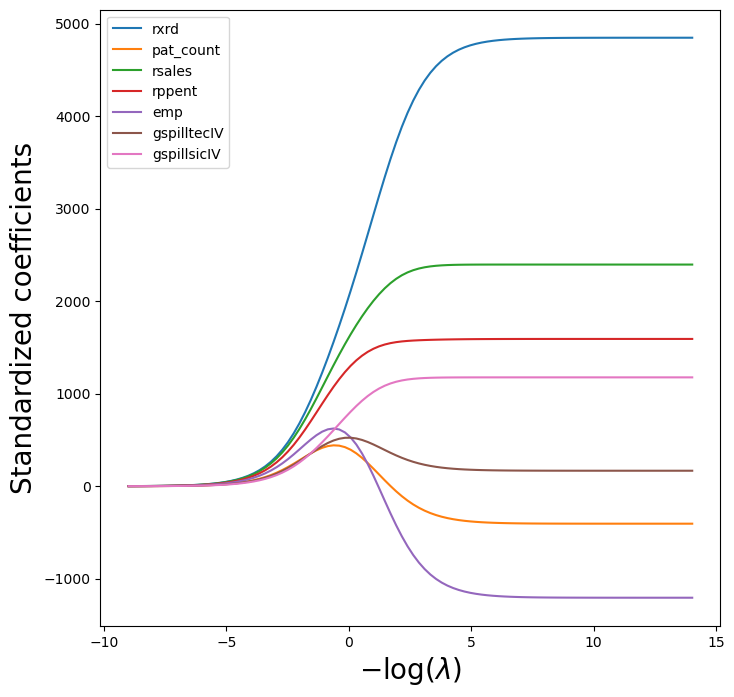

In [17]:
path_fig, ax = plt.subplots(figsize=(8,8))
soln_path.plot(ax=ax, legend=False)
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficients', fontsize=20)
ax.legend(loc='upper left')

# save figure
plt.savefig('ridge_coef.png')

## Cross-Validation plot

In [18]:
# Using K-fold CV w/ K=5
K = 5
kfold = skm.KFold(K,
                  random_state=0,
                  shuffle=True)

scaler = StandardScaler(with_mean=True,  with_std=True)
ridge = lm.ElasticNet(alpha=lambdas[59], l1_ratio=0)
pipe = Pipeline(steps=[('scaler', scaler), ('ridge', ridge)])

param_grid = {'ridge__alpha': lambdas}

grid = skm.GridSearchCV(pipe,
                        param_grid,
                        cv=kfold,
                        scoring='neg_mean_squared_error') 
grid.fit(X, Y)
grid.best_params_['ridge__alpha']
grid.best_estimator_

ridgeCV = lm.ElasticNetCV(alphas=lambdas,
                           l1_ratio=0,
                           cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('ridge', ridgeCV)])
pipeCV.fit(X, Y)

tuned_ridge = pipeCV.named_steps['ridge']

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.698e+11, tolerance: 1.740e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.502e+11, tolerance: 1.701e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.412e+11, tolerance: 1.051e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.423e+11, tolerance: 1.056e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.333e+11, tolerance: 1.056e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.275e+11, tolerance: 1.057e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.226e+11, tolerance: 1.057e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.038e+11, tolerance: 9.926e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.012e+11, tolerance: 9.926e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.747e+11, tolerance: 9.298e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.732e+11, tolerance: 9.298e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.187e+11, tolerance: 1.051e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.178e+11, tolerance: 1.051e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.217e+11, tolerance: 1.056e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.213e+11, tolerance: 1.056e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.171e+11, tolerance: 1.057e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.170e+11, tolerance: 1.057e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.985e+11, tolerance: 9.926e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.984e+11, tolerance: 9.926e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.717e+11, tolerance: 9.298e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.717e+11, tolerance: 9.298e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.170e+11, tolerance: 1.051e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.170e+11, tolerance: 1.051e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.209e+11, tolerance: 1.056e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.209e+11, tolerance: 1.056e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.168e+11, tolerance: 1.057e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.168e+11, tolerance: 1.057e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.983e+11, tolerance: 9.926e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.983e+11, tolerance: 9.926e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.716e+11, tolerance: 9.298e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.716e+11, tolerance: 9.298e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.170e+11, tolerance: 1.051e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.170e+11, tolerance: 1.051e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.209e+11, tolerance: 1.056e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.209e+11, tolerance: 1.056e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.168e+11, tolerance: 1.057e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.168e+11, tolerance: 1.057e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.983e+11, tolerance: 9.926e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 316873049894.24744, tolerance: 105705701.29629055
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 316857801712.4983, tolerance: 105705701.29629055
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: UserWarning: Coordina

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 311051219264.0425, tolerance: 92975378.35672489
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 305030072647.7236, tolerance: 92975378.35672489
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: UserWarning: Coordinate 

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.877e+11, tolerance: 1.272e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


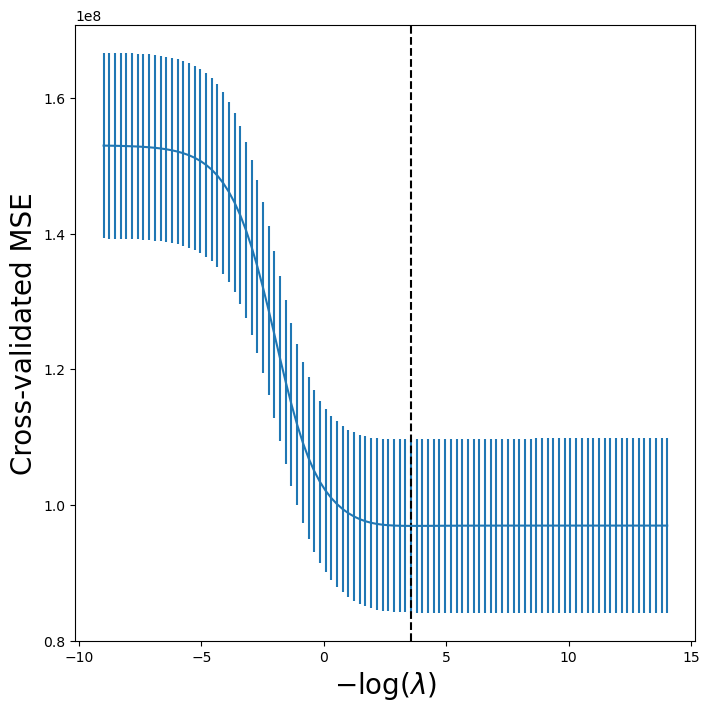

In [19]:
# Plot results
ridge_fig, ax = plt.subplots(figsize=(8,8))
ax.errorbar(-np.log(lambdas),
            -grid.cv_results_['mean_test_score'],
            yerr=grid.cv_results_['std_test_score'] / np.sqrt(K))
ax.axvline(-np.log(tuned_ridge.alpha_), c='k', ls='--')
#ax.set_ylim([80000000,220000000])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20)

# save figure
plt.savefig('ridge_cv.png')

# LASSO Regression

In [20]:
lassoCV = lm.ElasticNetCV(n_alphas=100,
                           l1_ratio=1,
                           cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('lasso', lassoCV)])
pipeCV.fit(X, Y)
tuned_lasso = pipeCV.named_steps['lasso']
tuned_lasso.alpha_

In [21]:
lambdas, soln_array = lm.Lasso.path(Xs,
                                    Y,
                                    l1_ratio=1,
                                    n_alphas=100)[:2]
soln_path = pd.DataFrame(soln_array.T,
                         columns=D.columns,
                         index=-np.log(lambdas))

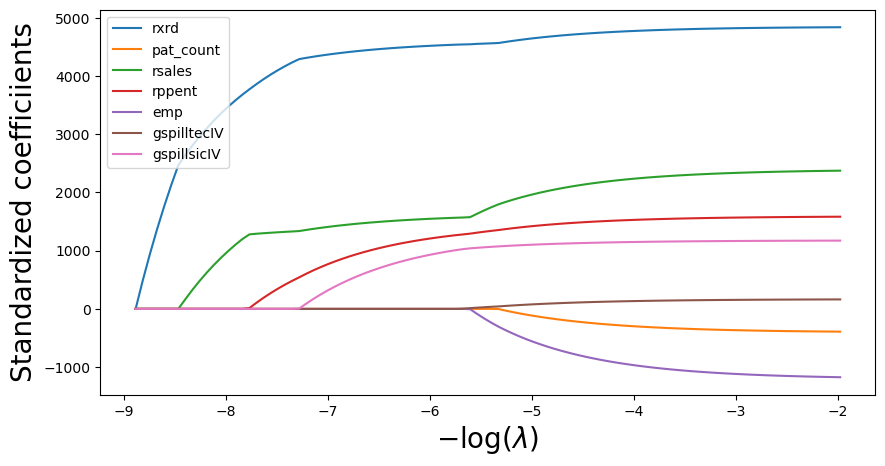

In [22]:
path_fig, ax = plt.subplots(figsize=(10,5))
soln_path.plot(ax=ax, legend=False)
ax.legend(loc='upper left')
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficiients', fontsize=20)

# save figure
plt.savefig('lasso_coef.png')

## Cross-Validation plot

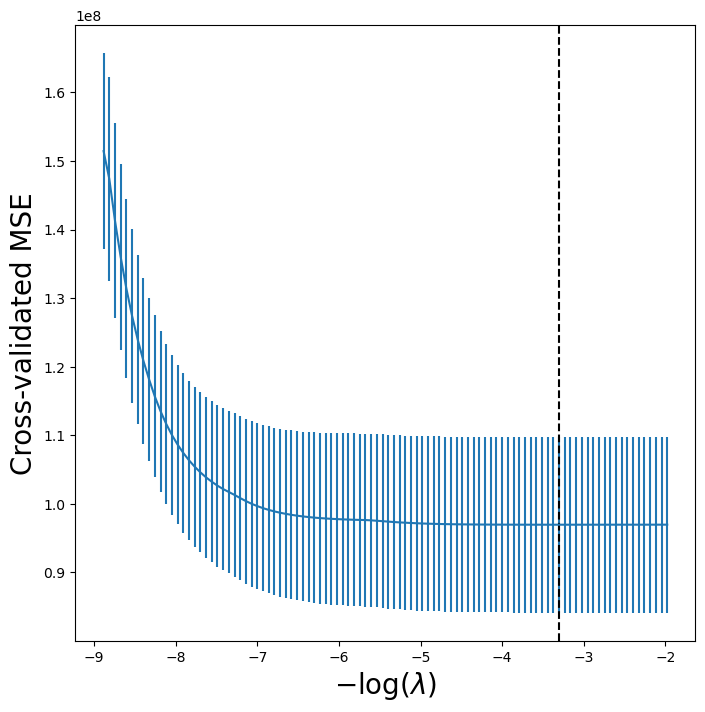

In [23]:
lassoCV_fig, ax = plt.subplots(figsize=(8,8))
ax.errorbar(-np.log(tuned_lasso.alphas_),
            tuned_lasso.mse_path_.mean(1),
            yerr=tuned_lasso.mse_path_.std(1) / np.sqrt(K))
ax.axvline(-np.log(tuned_lasso.alpha_), c='k', ls='--')
#ax.set_ylim([50000,250000])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20)

# save figure
plt.savefig('lasso_cv.png')

In [24]:
# comparing lambdas

# tuned alphas
print("LASSO: ", tuned_lasso.alpha_)
print("Ridge: ", tuned_ridge.alpha_)

LASSO:  27.168784527215628
Ridge:  0.028384053913137267


In [25]:
print(-np.log(tuned_lasso.alpha_))

-3.3020686865971527


# Regression Tree

In [26]:
# Splitting sample
(X_train,
 X_test,
 y_train,
 y_test) = skm.train_test_split(X,
                                df['rmkvaf'],
                                test_size=0.3,
                                random_state=0)
feature_names = list(D.columns)

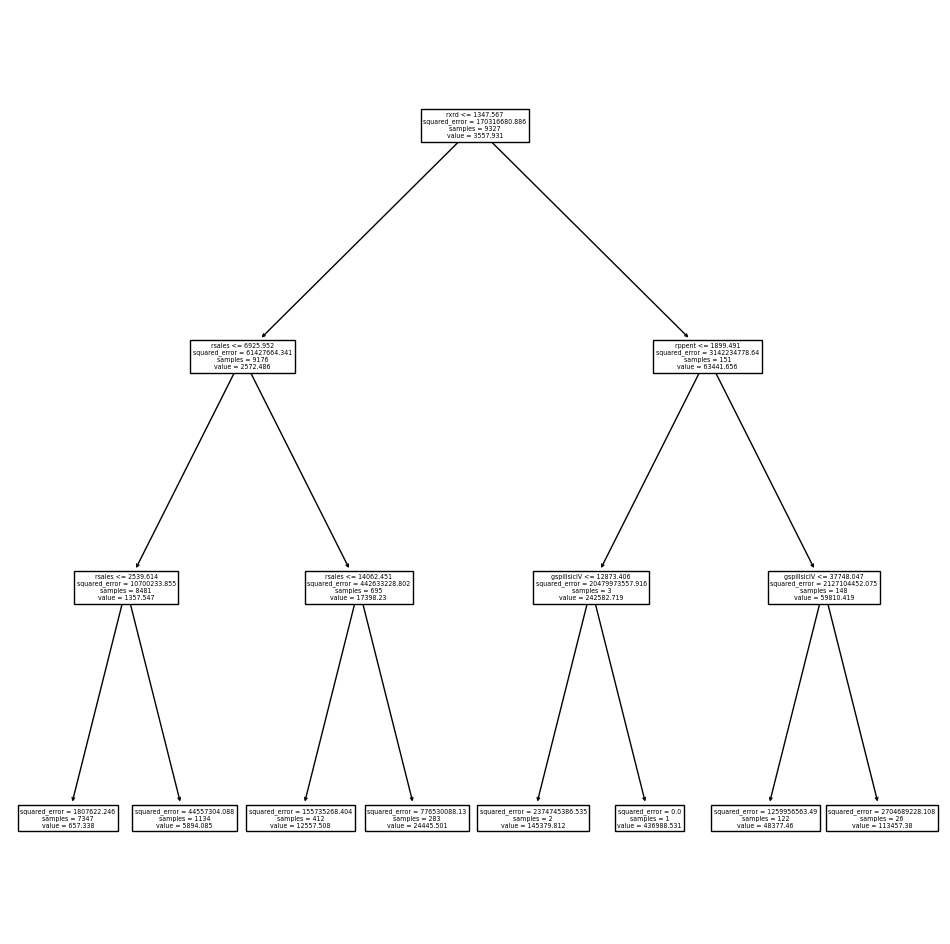

In [27]:
reg = DTR(max_depth=3)
reg.fit(X_train, y_train)
ax = plt.subplots(figsize=(12,12))[1]
plot_tree(reg,
          feature_names=feature_names,
          ax=ax);

In [28]:
# Find best pruning for tree
ccp_path = reg.cost_complexity_pruning_path(X_train, y_train)
kfold = skm.KFold(5,
                  shuffle=True,
                  random_state=10)
grid = skm.GridSearchCV(reg,
                        {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True, # retrains on best alpha
                        cv=kfold,
                        scoring='neg_mean_squared_error')
G = grid.fit(X_train, y_train)

In [29]:
# Get prediction error
best_ = grid.best_estimator_
tree_mse = np.mean((y_test - best_.predict(X_test))**2)
tree_mse

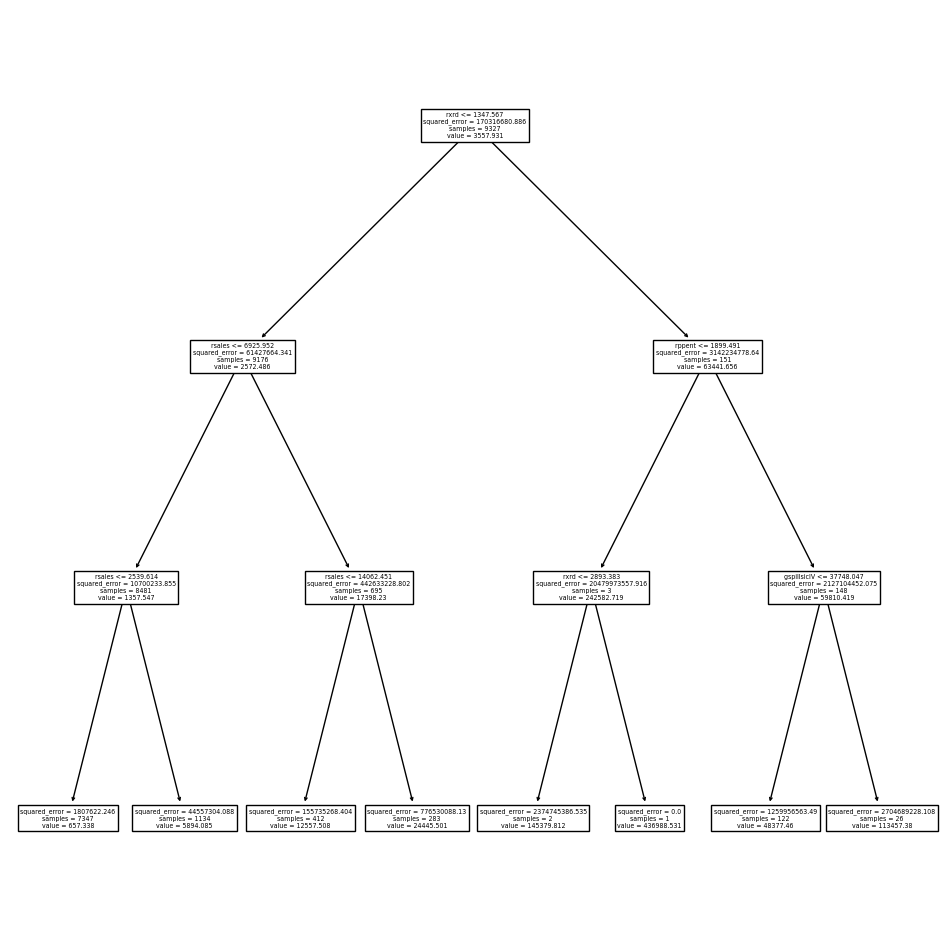

In [30]:
# Output pruned Regression Tree
ax = plt.subplots(figsize=(12,12))[1]
plot_tree(G.best_estimator_,
          feature_names=feature_names,
          ax=ax);
plt.savefig("pruned_tree.png")

# Random Forest

In [31]:
RF_tree = RF(max_features=3, # Random forest model
               random_state=0).fit(X_train, y_train)
y_hat_RF = RF_tree.predict(X_test)
rf_mse = np.mean((y_test - y_hat_RF)**2)
rf_mse

In [32]:
feature_imp = pd.DataFrame(
    {'importance':RF_tree.feature_importances_},
    index=feature_names) # Must include feature importance in report
feature_imp = feature_imp.sort_values(by='importance', ascending=False)
feature_imp

,importance
rxrd,0.303054
rsales,0.230557
rppent,0.142841
gspillsicIV,0.111545
emp,0.105906
gspilltecIV,0.066526
pat_count,0.039571


Text(0.5, 1.0, 'Importance of Random Forest Regressors for Firm Market Value')

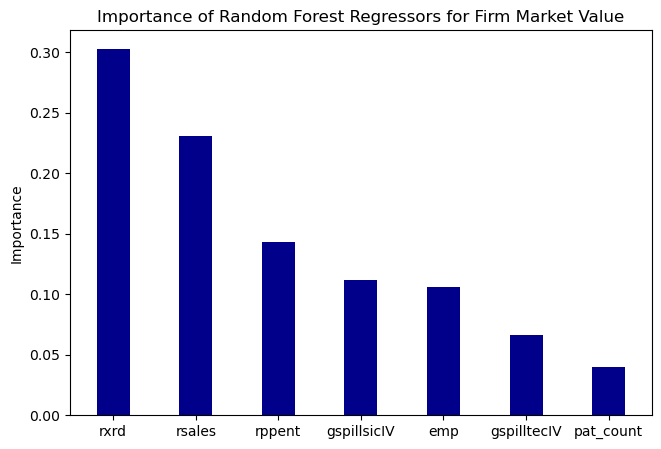

In [33]:
# print(feature_imp.sort_values(by='importance', ascending=False).to_latex()) # print latex output

# plot importance values
fig = plt.figure(figsize=(7.5,5))

plt.bar(feature_imp.index, feature_imp.importance, color ='darkblue', 
        width = 0.4)
plt.ylabel('Importance')
plt.title('Importance of Random Forest Regressors for Firm Market Value')

# Bagging

In [34]:
bag = RF(max_features=X_train.shape[1], random_state=0)
bag.fit(X_train, y_train)

RandomForestRegressor(max_features=7, random_state=0)

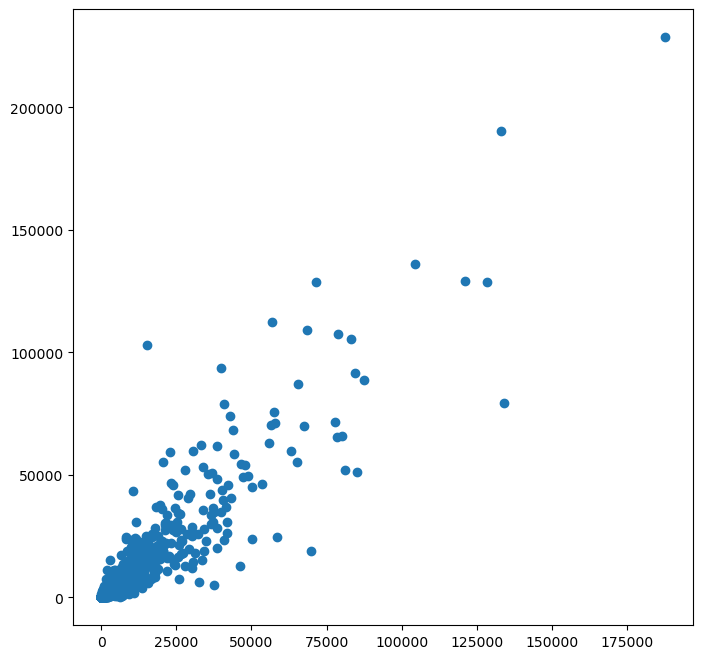

In [35]:
ax = plt.subplots(figsize=(8,8))[1]
y_hat_bag = bag.predict(X_test)
ax.scatter(y_hat_bag, y_test)
bag_mse = np.mean((y_test - y_hat_bag)**2)
bag_mse

# Boosting

In [36]:
boost = GBR(n_estimators=5000, # Gradient Boosting Regressor
                   learning_rate=0.001,
                   max_depth=3,
                   random_state=0)
boost.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.001, n_estimators=5000,
                          random_state=0)

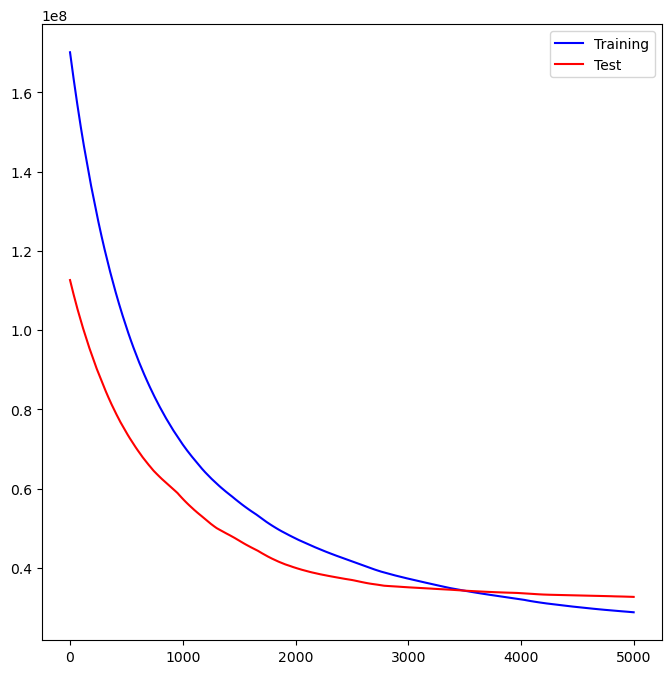

In [37]:
test_error = np.zeros_like(boost.train_score_)
for idx, y_ in enumerate(boost.staged_predict(X_test)):
   test_error[idx] = np.mean((y_test - y_)**2)

plot_idx = np.arange(boost.train_score_.shape[0])
ax = plt.subplots(figsize=(8,8))[1]
ax.plot(plot_idx,
        boost.train_score_,
        'b',
        label='Training')
ax.plot(plot_idx,
        test_error,
        'r',
        label='Test')
ax.legend();

boost_mse = min(test_error)

Mean Squared Error: 53809940.0
Prev. MSE: 40865396.0


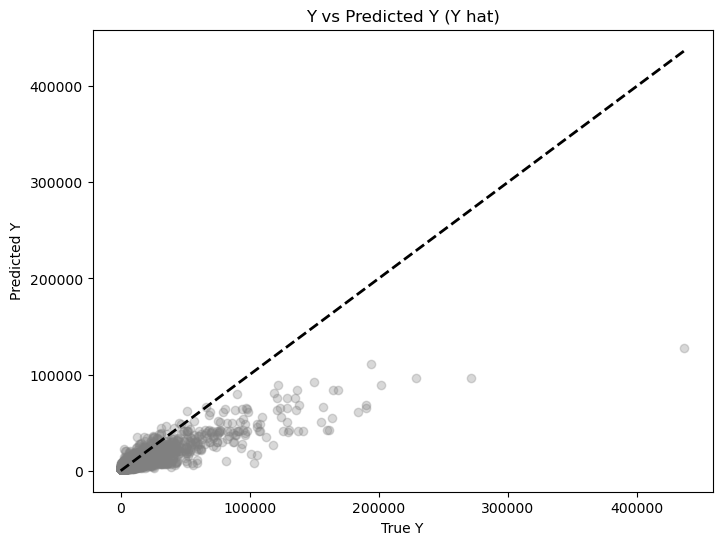

In [38]:
# XG Boost
y = df['rmkvaf']
# Convert the data into XGBoost's DMatrix format
dtrain = xgb.DMatrix(X, label=y)

# Define the parameters for the XGBoost model
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'eta': 0.1,
    'max_depth': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

# Train the XGBoost model with the optimal number of boosting rounds
model = xgb.train(params, dtrain, num_boost_round= 10)

# Make predictions 
y_pred = model.predict(dtrain)

# Calculate and print the Mean Squared Error (MSE)
mse = mean_squared_error(y, y_pred)
print("Mean Squared Error:", mse)
print("Prev. MSE: 40865396.0")

plt.figure(figsize=(8, 6))
plt.scatter(y, y_pred, c='grey', alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('True Y')
plt.ylabel('Predicted Y')
plt.title('Y vs Predicted Y (Y hat)')
plt.show()

# Comparing Test Errors

In [39]:
# Tree
print('Tree: ', tree_mse)
# Bag
print('Bag: ', bag_mse)
# Random Forest
print('Random Forest: ', rf_mse)
# Boost
print('Boost: ', boost_mse)

# Make table
error_tbl = {
    'model' : ['Tree', 'Bag', 'Random Forest', 'Boost'],
    'MSE' : [tree_mse, bag_mse, rf_mse, boost_mse]
}
error_tbl = pd.DataFrame(data=error_tbl)
print(error_tbl.to_latex())

Tree:  53530989.87243649
Bag:  16896083.225845523
Random Forest:  17713049.08429623
Boost:  32678662.643215105
\begin{tabular}{llr}
\toprule
 & model & MSE \\
\midrule
0 & Tree & 53530989.872436 \\
1 & Bag & 16896083.225846 \\
2 & Random Forest & 17713049.084296 \\
3 & Boost & 32678662.643215 \\
\bottomrule
\end{tabular}



# Predicting Market value of spillovers across years

In [40]:
# Use Optimal LASSO coefficients - remember to rescale from their standardization back to unit values.
print(x_vars.columns[1],': ',tuned_lasso.coef_[0]) # index 0 for x_vars is constant term
print(x_vars.columns[2],': ',tuned_lasso.coef_[1]) # so 1st variable is at index 1


gspilltecIV :  4809.362016403995
gspillsicIV :  -352.0895602447208


In [41]:
# rescaling lasso coefficients
coef_tec = tuned_lasso.coef_[0]/df['gspilltecIV'].std()
coef_sic = tuned_lasso.coef_[1]/df['gspillsicIV'].std() 

In [42]:
df['firmval_tec'] = df['gspilltecIV']*coef_tec
df['firmval_sic'] = df['gspillsicIV']*coef_sic

In [43]:
df[['rmkvaf','firmval_tec','firmval_sic']]

,rmkvaf,firmval_tec,firmval_sic
0,2314.207764,5975.001465,-391.839294
1,1288.770630,5833.845703,-382.459259
2,1756.920532,5747.703125,-376.848724
3,8698.285156,5714.716797,-372.497253
4,10707.480469,5784.362793,-376.836273
...,...,...,...
13380,1200.901245,9066.891602,-1239.664551
13381,1264.767578,9276.417969,-1268.360474
13382,1033.856079,9522.323242,-1296.008911
13383,981.391479,9800.909180,-1327.834595


In [44]:
print(df['rmkvaf'].sum())
print(df['firmval_tec'].sum())
# Generate predictions for each firm

# Aggregate across years

45665948.0
84164990.0


# Impact of spillovers on firm value over time

In [45]:
# Include confidence intervals. Use 2 or 5 year intervals if need more statistical power
# Try with PLR DML to compare results - separate bar i.e. for each year, one OLS bar and one DML bar
# Separate plots for tech/product market spillovers

# build year-spillover interaction terms
years = df.year.sort_values().unique()
years = years[1:] # remove first year as ref category

spillovers = ['gspilltecIV','gspillsicIV']

for spillover in spillovers:
    for year in years:
        col_name = f"{spillover}X{year}"
        x_vars[col_name] = x_vars[spillover]*x_vars[year]

# drop reference year dummy
#x_vars = x_vars.drop(columns=['1981'])
#fixed_effects.remove('1981')

In [46]:
# Estimate effect of spillovers on firm value, OLS w/o firm FE's. Estimate spillovers separately, then together.

# Full model
year_model1 = sm.OLS(y_var,x_vars).fit()
year_model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rmkvaf   R-squared:                       0.669
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                     31.93
Date:                Wed, 16 Oct 2024   Prob (F-statistic):               0.00
Time:                        02:02:58   Log-Likelihood:            -1.4150e+05
No. Observations:               13385   AIC:                         2.846e+05
Df Residuals:                   12587   BIC:                         2.906e+05
Df Model:                         797                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.381e+04   4167.202     -3.315      0.001    -2.2e+04   -5645.690
gspilltecIV          0.1986      0.145      1.368      0.171      -0.086       0.483
gspillsicIV          0.6659      0.233      2.852      0.004       0.208       1.124
pat_count          -27.0286      1.911    -14.141      0.000     -30.775     -23.282
rsales               0.7667      0.037     20.685      0.000       0.694       0.839
rppent               0.6251      0.084      7.408      0.000       0.460       0.790
emp                 15.4383      7.160      2.156      0.031       1.404      29.473
rxrd                18.8001      0.613     30.654      0.000      17.598      20.002
1981               109.6592   1080.584      0.101      0.919   -2008.450    2227.768
1982              -233.2389   1074.271     -0.217      0.828   -2338.975    1872.497
1983              -128.6822   1065.010     -0.121      0.904   -2216.264    1958.899
1984                98.8470   1059.772      0.093      0.926   -1978.467    2176.161
1985               500.7900   1057.845      0.473      0.636   -1572.747    2574.327
1986              1025.5479   1047.722      0.979      0.328   -1028.146    3079.242
1987               964.1585   1043.238      0.924      0.355   -1080.748    3009.065
1988              1227.5616   1042.827      1.177      0.239    -816.538    3271.662
1989              1409.3119   1037.820      1.358      0.175    -624.973    3443.597
1990              1582.7353   1032.683      1.533      0.125    -441.480    3606.951
1991              1616.4231   1032.392      1.566      0.117    -407.222    3640.068
1992              1589.4573   1031.336      1.541      0.123    -432.118    3611.033
1993              1205.1245   1027.138      1.173      0.241    -808.222    3218.471
1994              1111.0146   1029.798      1.079      0.281    -907.547    3129.576
1995              1413.9353   1028.108      1.375      0.169    -601.312    3429.183
1996              1164.7069   1030.027      1.131      0.258    -854.302    3183.716
1997              1327.6436   1034.933      1.283      0.200    -700.983    3356.271
1998               626.1367   1038.418      0.603      0.547   -1409.322    2661.595
1999             -1672.8117   1048.945     -1.595      0.111   -3728.904     383.281
2000                14.3278   1070.432      0.013      0.989   -2083.883    2112.539
2001              1048.8243   1114.791      0.941      0.347   -1136.337    3233.986
10005.0           1.075e+04   3748.461      2.868      0.004    3402.447    1.81e+04
10006.0            1.05e+04   3980.492      2.637      0.008    2694.217    1.83e+04
10008.0           9625.6040   3498.425      2.751      0.006    2768.158    1.65e+04
10016.0           1.086e+04   3609.282      3.009      0.003    3784.555    1.79e+04
10030.0           1.211

In [47]:
# Tech spillovers model, no firm FE's
drop_columns = [col for col in x_vars.columns if 'gspillsicIV' in col]
x_vars_nofe = x_vars.drop(columns=fixed_effects)
x_vars_nofe = x_vars_nofe.drop(columns=drop_columns)

year_model2 = sm.OLS(y_var,x_vars_nofe).fit()
year_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rmkvaf   R-squared:                       0.358
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                     275.7
Date:                Wed, 16 Oct 2024   Prob (F-statistic):               0.00
Time:                        02:02:59   Log-Likelihood:            -1.4593e+05
No. Observations:               13385   AIC:                         2.919e+05
Df Residuals:                   13357   BIC:                         2.921e+05
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1170.0198    203.818      5.741      0.000     770.508    1569.532
gspilltecIV         -0.0529      0.039     -1.368      0.171      -0.129       0.023
pat_count           -9.5652      1.825     -5.241      0.000     -13.142      -5.988
rsales               0.4633      0.034     13.628      0.000       0.397       0.530
rppent               0.4524      0.048      9.398      0.000       0.358       0.547
emp                -37.6440      3.501    -10.753      0.000     -44.506     -30.782
rxrd                12.1159      0.463     26.146      0.000      11.208      13.024
gspilltecIVX1981    -0.0200      0.050     -0.399      0.690      -0.118       0.078
gspilltecIVX1982    -0.0029      0.049     -0.060      0.953      -0.100       0.094
gspilltecIVX1983     0.0100      0.048      0.209      0.835      -0.084       0.104
gspilltecIVX1984    -0.0064      0.047     -0.136      0.892      -0.098       0.086
gspilltecIVX1985    -0.0011      0.046     -0.024      0.981      -0.091       0.089
gspilltecIVX1986     0.0009      0.045      0.021      0.983      -0.087       0.089
gspilltecIVX1987     0.0010      0.044      0.023      0.981      -0.086       0.088
gspilltecIVX1988    -0.0061      0.044     -0.138      0.890      -0.092       0.080
gspilltecIVX1989     0.0085      0.043      0.196      0.845      -0.076       0.093
gspilltecIVX1990    -0.0048      0.043     -0.113      0.910      -0.089       0.079
gspilltecIVX1991     0.0184      0.042      0.433      0.665      -0.065       0.101
gspilltecIVX1992     0.0194      0.042      0.461      0.645      -0.063       0.102
gspilltecIVX1993     0.0334      0.042      0.801      0.423      -0.048       0.115
gspilltecIVX1994     0.0308      0.042      0.742      0.458      -0.051       0.112
gspilltecIVX1995     0.0607      0.041      1.472      0.141      -0.020       0.141
gspilltecIVX1996     0.0883      0.041      2.160      0.031       0.008       0.168
gspilltecIVX1997     0.1267      0.041      3.120      0.002       0.047       0.206
gspilltecIVX1998     0.1688      0.040      4.177      0.000       0.090       0.248
gspilltecIVX1999     0.2330      0.040      5.779      0.000       0.154       0.312
gspilltecIVX2000     0.2164      0.040      5.354      0.000       0.137       0.296
gspilltecIVX2001     0.1534      0.041      3.778      0.000       0.074       0.233
==============================================================================
Omnibus:                    23791.941   Durbin-Watson:                   0.353
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         58097440.358
Skew:                          12.502   Prob(JB):                         0.00
Kurtosis:                     324.786   Cond. No.                     5.02e+04
=====================================================

In [48]:
# Tech spillovers model, firm FE's
x_vars_fe = x_vars.drop(columns=drop_columns)

year_model3 = sm.OLS(y_var,x_vars_fe).fit()
year_model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rmkvaf   R-squared:                       0.667
Model:                            OLS   Adj. R-squared:                  0.647
Method:                 Least Squares   F-statistic:                     32.62
Date:                Wed, 16 Oct 2024   Prob (F-statistic):               0.00
Time:                        02:03:00   Log-Likelihood:            -1.4153e+05
No. Observations:               13385   AIC:                         2.846e+05
Df Residuals:                   12609   BIC:                         2.904e+05
Df Model:                         775                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.404e+04   4166.434     -3.371      0.001   -2.22e+04   -5877.761
gspilltecIV          0.4517      0.123      3.677      0.000       0.211       0.693
pat_count          -27.4800      1.908    -14.400      0.000     -31.221     -23.739
rsales               0.7669      0.037     20.684      0.000       0.694       0.840
rppent               0.5705      0.084      6.780      0.000       0.406       0.735
emp                 12.9965      7.160      1.815      0.070      -1.038      27.031
rxrd                19.7263      0.598     32.993      0.000      18.554      20.898
1981               110.3657   1080.039      0.102      0.919   -2006.675    2227.406
1982              -243.4640   1072.952     -0.227      0.820   -2346.613    1859.685
1983              -114.3389   1063.325     -0.108      0.914   -2198.618    1969.940
1984               115.2448   1057.289      0.109      0.913   -1957.203    2187.692
1985               542.6004   1055.171      0.514      0.607   -1525.695    2610.895
1986              1069.3608   1045.395      1.023      0.306    -979.773    3118.495
1987              1025.4005   1040.967      0.985      0.325   -1015.054    3065.855
1988              1291.3045   1041.029      1.240      0.215    -749.270    3331.879
1989              1514.1450   1036.323      1.461      0.144    -517.206    3545.496
1990              1689.8009   1031.752      1.638      0.101    -332.589    3712.191
1991              1757.6723   1031.035      1.705      0.088    -263.313    3778.657
1992              1663.9210   1030.301      1.615      0.106    -355.627    3683.469
1993              1275.2181   1026.193      1.243      0.214    -736.277    3286.713
1994              1193.1166   1028.610      1.160      0.246    -823.115    3209.348
1995              1591.0463   1026.610      1.550      0.121    -421.265    3603.357
1996              1293.6561   1028.769      1.257      0.209    -722.888    3310.200
1997              1571.4228   1033.392      1.521      0.128    -454.183    3597.029
1998              1015.9035   1036.611      0.980      0.327   -1016.012    3047.819
1999             -1264.8357   1047.178     -1.208      0.227   -3317.464     787.792
2000               683.4387   1067.982      0.640      0.522   -1409.969    2776.846
2001              1290.2571   1113.123      1.159      0.246    -891.633    3472.147
10005.0           8336.4171   3699.630      2.253      0.024    1084.579    1.56e+04
10006.0           7128.2051   3884.307      1.835      0.067    -485.627    1.47e+04
10008.0           6433.2934   3402.253      1.891      0.059    -235.640    1.31e+04
10016.0           7164.4693   3479.856      2.059      0.040     343.423     1.4e+04
10030.0           1.086e+04   4142.866      2.621      0.009    2739.409     1.9e+04
1004.0            9386.

Results highly depend on the firm FE's. Wrong sign for tech, insignificant for product market. Unobserved firm-related variables play a role?

In [49]:
# Product spillovers model, no firm FE's
drop_columns = [col for col in x_vars.columns if 'gspilltecIV' in col]
x_vars_nofe = x_vars.drop(columns=fixed_effects)
x_vars_nofe = x_vars_nofe.drop(columns=drop_columns)

year_model4 = sm.OLS(y_var,x_vars_nofe).fit()
year_model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rmkvaf   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     274.6
Date:                Wed, 16 Oct 2024   Prob (F-statistic):               0.00
Time:                        02:03:01   Log-Likelihood:            -1.4594e+05
No. Observations:               13385   AIC:                         2.919e+05
Df Residuals:                   13357   BIC:                         2.921e+05
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              946.3154    147.629      6.410      0.000     656.941    1235.689
gspillsicIV         -0.0600      0.102     -0.586      0.558      -0.260       0.141
pat_count          -11.1614      1.793     -6.225      0.000     -14.676      -7.647
rsales               0.5112      0.034     15.126      0.000       0.445       0.577
rppent               0.4669      0.048      9.689      0.000       0.372       0.561
emp                -39.4619      3.475    -11.355      0.000     -46.274     -32.650
rxrd                11.4031      0.470     24.284      0.000      10.483      12.324
gspillsicIVX1981    -0.0376      0.136     -0.278      0.781      -0.303       0.228
gspillsicIVX1982    -0.0165      0.133     -0.124      0.902      -0.277       0.244
gspillsicIVX1983     0.0010      0.129      0.008      0.994      -0.253       0.255
gspillsicIVX1984    -0.0235      0.126     -0.186      0.852      -0.271       0.224
gspillsicIVX1985    -0.0079      0.124     -0.064      0.949      -0.251       0.235
gspillsicIVX1986     0.0070      0.121      0.058      0.954      -0.230       0.244
gspillsicIVX1987     0.0052      0.118      0.044      0.965      -0.227       0.237
gspillsicIVX1988    -0.0086      0.117     -0.073      0.942      -0.239       0.222
gspillsicIVX1989     0.0257      0.116      0.222      0.825      -0.201       0.253
gspillsicIVX1990     0.0151      0.114      0.132      0.895      -0.209       0.239
gspillsicIVX1991     0.0634      0.113      0.563      0.573      -0.157       0.284
gspillsicIVX1992     0.0415      0.112      0.370      0.711      -0.178       0.261
gspillsicIVX1993     0.0532      0.111      0.479      0.632      -0.164       0.271
gspillsicIVX1994     0.0527      0.111      0.476      0.634      -0.164       0.270
gspillsicIVX1995     0.1206      0.110      1.098      0.272      -0.095       0.336
gspillsicIVX1996     0.1585      0.109      1.451      0.147      -0.056       0.372
gspillsicIVX1997     0.2513      0.109      2.315      0.021       0.039       0.464
gspillsicIVX1998     0.3606      0.108      3.339      0.001       0.149       0.572
gspillsicIVX1999     0.4666      0.108      4.328      0.000       0.255       0.678
gspillsicIVX2000     0.5090      0.108      4.718      0.000       0.298       0.720
gspillsicIVX2001     0.3331      0.108      3.073      0.002       0.121       0.546
==============================================================================
Omnibus:                    24023.522   Durbin-Watson:                   0.353
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         61844043.678
Skew:                          12.758   Prob(JB):                         0.00
Kurtosis:                     335.022   Cond. No.                     1.57e+04
=====================================================

In [50]:
# Product spillovers model, firm FE's
x_vars_fe = x_vars.drop(columns=drop_columns)

year_model5 = sm.OLS(y_var,x_vars_fe).fit()
year_model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rmkvaf   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                     32.48
Date:                Wed, 16 Oct 2024   Prob (F-statistic):               0.00
Time:                        02:03:03   Log-Likelihood:            -1.4155e+05
No. Observations:               13385   AIC:                         2.847e+05
Df Residuals:                   12609   BIC:                         2.905e+05
Df Model:                         775                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.059e+04   2858.143     -3.705      0.000   -1.62e+04   -4986.834
gspillsicIV          0.8770      0.199      4.412      0.000       0.487       1.267
pat_count          -29.6820      1.861    -15.948      0.000     -33.330     -26.034
rsales               0.7906      0.037     21.566      0.000       0.719       0.862
rppent               0.6416      0.084      7.603      0.000       0.476       0.807
emp                 12.1477      7.031      1.728      0.084      -1.633      25.929
rxrd                18.7054      0.614     30.479      0.000      17.502      19.908
1981              -323.9459    749.124     -0.432      0.665   -1792.342    1144.450
1982              -175.3555    747.071     -0.235      0.814   -1639.729    1289.018
1983              -106.8254    738.681     -0.145      0.885   -1554.753    1341.102
1984              -358.0670    734.939     -0.487      0.626   -1798.660    1082.526
1985              -339.9200    734.792     -0.463      0.644   -1780.223    1100.383
1986              -333.0589    729.764     -0.456      0.648   -1763.507    1097.389
1987              -418.4831    726.215     -0.576      0.564   -1841.975    1005.009
1988              -537.8235    725.635     -0.741      0.459   -1960.179     884.531
1989              -394.3985    723.074     -0.545      0.585   -1811.734    1022.937
1990              -723.8705    719.942     -1.005      0.315   -2135.066     687.325
1991              -405.2199    718.078     -0.564      0.573   -1812.763    1002.323
1992              -200.8668    716.324     -0.280      0.779   -1604.970    1203.236
1993               -60.0251    714.587     -0.084      0.933   -1460.725    1340.675
1994              -213.6207    716.211     -0.298      0.766   -1617.503    1190.261
1995               162.8964    716.020      0.228      0.820   -1240.612    1566.405
1996               673.3490    718.687      0.937      0.349    -735.387    2082.085
1997               981.4864    721.476      1.360      0.174    -432.716    2395.689
1998               793.8169    725.956      1.093      0.274    -629.167    2216.801
1999              1042.6699    732.548      1.423      0.155    -393.235    2478.575
2000               473.6464    750.844      0.631      0.528    -998.123    1945.415
2001               461.9434    779.875      0.592      0.554   -1066.731    1990.618
10005.0           9659.3047   3429.640      2.816      0.005    2936.688    1.64e+04
10006.0           9654.2887   3848.511      2.509      0.012    2110.621    1.72e+04
10008.0           9065.5709   3369.549      2.690      0.007    2460.743    1.57e+04
10016.0           1.032e+04   3471.639      2.971      0.003    3510.375    1.71e+04
10030.0           1.032e+04   3484.519      2.962      0.003    3490.881    1.72e+04
1004.0             1.04

In [61]:
# grab estimates. Add non-interactive term to each year coefficient
# Build Dataframe of year, coefficient, conf intervals

# use years to interate through
# years = np.append(years, '1981')
# years = years.sort_values()

ref_year = '1980'
time_coefs_sic = {
    'year': np.append(years,ref_year),
    'coef': [np.nan for i in range(0,len(years)+1)],
    'CI_l': [np.nan for i in range(0,len(years)+1)],
    'CI_h': [np.nan for i in range(0,len(years)+1)],
    'se': [np.nan for i in range(0,len(years)+1)]
}

time_coefs_sic = pd.DataFrame(time_coefs_sic)
time_coefs_sic = time_coefs_sic.sort_values(by='year').reset_index(drop=True)

conf_intervals = year_model5.conf_int(alpha=0.05, cols=None)
s_errors = year_model5.HC0_se

# grab coefficients and confidence intervals
ref_year = '1980'
coef_ref = year_model5.params['gspillsicIV'] # coef for ref year category
l_ref = conf_intervals.loc[conf_intervals.index == 'gspillsicIV',0].values[0] # conf interval for ref cat
h_ref = conf_intervals.loc[conf_intervals.index == 'gspillsicIV',1].values[0]

for year in time_coefs_sic['year'].unique():
    if year == ref_year:
        coef = coef_ref
        ci_l = 0 
        ci_h = 0
        
        time_coefs_sic.loc[time_coefs_sic['year'] == year, 'coef'] = coef
        time_coefs_sic.loc[time_coefs_sic['year'] == year, 'CI_l'] = ci_l
        time_coefs_sic.loc[time_coefs_sic['year'] == year, 'CI_h'] = ci_h
        
    else:
        col_name = f"gspillsicIVX{year}"
        coef = year_model5.params[col_name] + coef_ref
        ci_l = conf_intervals.loc[conf_intervals.index == col_name,0].values[0] + coef_ref
        ci_h = conf_intervals.loc[conf_intervals.index == col_name,1].values[0] + coef_ref
        
        time_coefs_sic.loc[time_coefs_sic['year'] == year, 'coef'] = coef
        time_coefs_sic.loc[time_coefs_sic['year'] == year, 'CI_l'] = ci_l
        time_coefs_sic.loc[time_coefs_sic['year'] == year, 'CI_h'] = ci_h




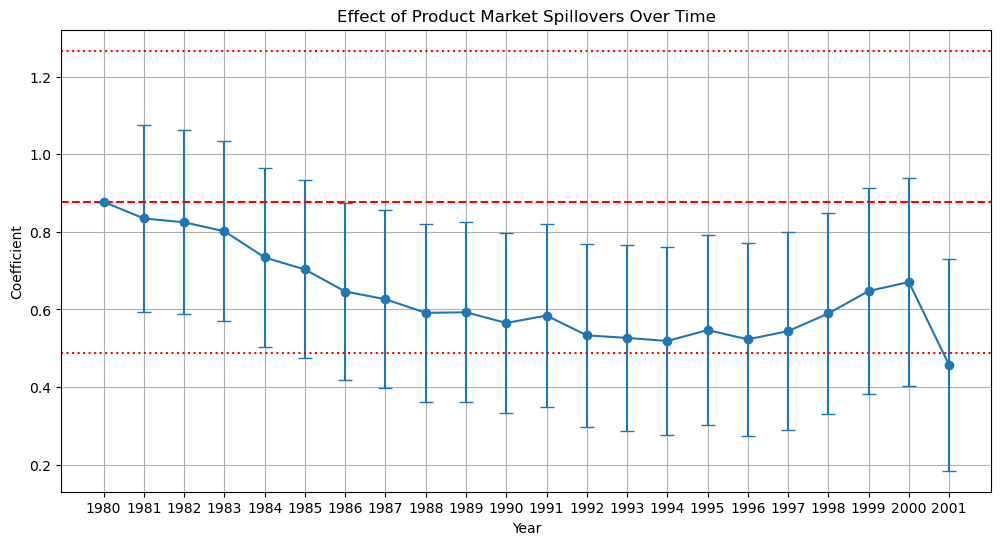

In [62]:
time_coefs_sic['upper'] = time_coefs_sic['CI_h'] - time_coefs_sic['coef']
time_coefs_sic['lower'] = time_coefs_sic['coef'] - time_coefs_sic['CI_l']
time_coefs_sic.loc[time_coefs_sic['year'] == ref_year, ['upper','lower']] = 0

cis = time_coefs_sic[['lower','upper']].T
# Plotting
plt.figure(figsize=(12, 6))
plt.errorbar(x=time_coefs_sic['year'],y=time_coefs_sic['coef'],yerr=cis, capsize=5, marker='o')
plt.axhline(y=coef_ref, linestyle='dashed', color='r')
plt.axhline(y=l_ref, linestyle='dotted', color='r')
plt.axhline(y=h_ref, linestyle='dotted', color='r')
plt.xlabel('Year')
plt.ylabel('Coefficient')
plt.title('Effect of Product Market Spillovers Over Time')
plt.grid(True)
plt.show()

# DAG model and testing

In [53]:
DAG3 = """graph [
directed 1

node [
    id 0
    label "rmkvaf"
    ]

node [
    id 1
    label "rxrd"
    ]
    
node [
    id 2
    label "rsales"
    ]

node [
    id 3
    label "gspilltecIV"
    ]

node [
    id 4
    label "gspillsicIV"
    ]

node [
    id 5
    label "pat_count"
    ]

node [
    id 7
    label "rppent"
    ]

edge [
    source 5
    target 0
    ]

edge [
    source 5
    target 7
    ]


edge [
    source 3
    target 1
    ]


edge [
    source 4
    target 1
    ]


edge [
    source 4
    target 2
    ]


edge [
    source 1
    target 7
    ]


edge [
    source 1
    target 5
    ]


edge [
    source 7
    target 2
    ]


edge [
    source 2
    target 0
    ]

edge [
    source 7
    target 0
    ]

]
    
    """

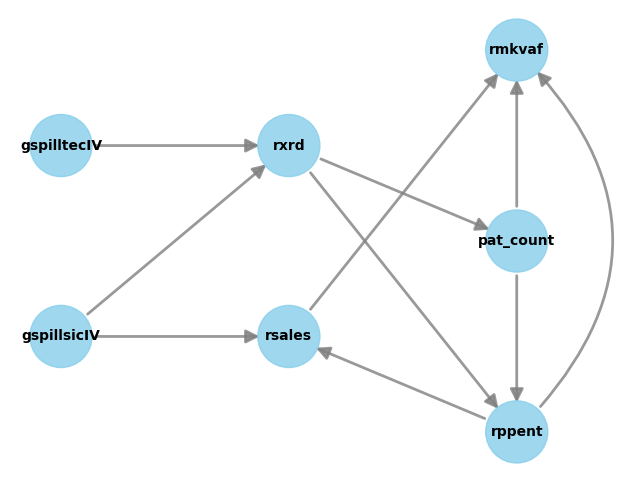

In [54]:
model = CausalModel(
    data=df,
    treatment='gspilltecIV',
    outcome='rmkvaf',
    graph=DAG3)

model.view_model()

In [55]:
# identify estimand
estimand = model.identify_effect()
print(estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                  
──────────────(E[rmkvaf])
d[gspilltecIV]           
Estimand assumption 1, Unconfoundedness: If U→{gspilltecIV} and U→rmkvaf then P(rmkvaf|gspilltecIV,,U) = P(rmkvaf|gspilltecIV,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
Estimand expression:
 ⎡                d                                ∂                          
E⎢──────────────────────────────────(rmkvaf)⋅──────────────([pat_count  rppent
 ⎣d[pat_count  rppent  rsales  rxrd]         ∂[gspilltecIV]                   

                ⎤
  rsales  rxrd])⎥
                ⎦
Estimand assumption 1, Full-mediation: pat_count,rppent,rsales,rxrd intercepts (blocks) all directed paths from gspilltecIV to r,m,k,v,a,f.
Estimand assumption 2, First-stage-unconfoundedness: If U→{gspilltecIV} and U→{pat_count,rppent,rsales,rxrd} then P(pat_count,

In [56]:
# obtain estimates
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.linear_regression')

print(estimate.value)

0.12296998685320659


In [57]:
# refutation test
refute_subset = model.refute_estimate(
    estimand=estimand,
    estimate=estimate,
    method_name="data_subset_refuter",
    subset_fraction=0.4)

print(refute_subset)

Refute: Use a subset of data
Estimated effect:0.12296998685320659
New effect:0.12347458135323676
p value:0.9199999999999999



# Scrap Code

X_spills = df[['gspilltecIV', 'gspillsicIV']]

(X_trainsp,
 X_testsp,
 y_trainsp,
 y_testsp) = skm.train_test_split(X_spills,
                                df['rmkvaf'],
                                test_size=0.3,
                                random_state=0) 

In [58]:
# # Try a neural network
# one_layers = [
#     (1),
#     (2),
#     (3),
#     (4),
#     (5)
# ]

# two_layers = [
#     (1,1),(1,2),(1,3),
#     (2,1),(2,2),(2,3),(2,4),
#     (3,1),(3,2),(3,3),(3,4),(3,5),
#     (4,1),(4,2),(4,3),(4,4),(4,5),
#     (5,1),(5,2),(5,3),(5,4),(5,5)
# ]

# # Use DML with a PLR equation, keeping spillovers entering linearly
# # Use Random Forest as the ML model

# # Specify doubleML data model

# x_vars = ['pat_count','rsales','rppent','emp','rxrd']
# data_dml_tec = dml.DoubleMLData(df,
#                                  y_col='rmkvaf',
#                                  d_cols='gspilltec',
#                                  x_cols=x_vars)

# RF_DML = RF(max_features=3, random_state=0)

# # Implement PLR DML estimation with gspilltec linear

# dml_plr_tec = dml.DoubleMLPLR(data_dml_tec,
#                                 ml_l = RF_DML,
#                                 ml_m = RF_DML,
#                                 n_folds = 3)

# dml_plr_tec.fit(store_predictions=True)
# print(dml_plr_tec.summary)